In [ ]:
#To Do: Try SyntaxNet

In [ ]:
import pandas as pd

In [ ]:
#df=pd.read_csv('B_Tweet_Data_Processed/B_GetOldTweet_bitcoin_GetNum_.csv')

In [ ]:
df=pd.read_csv('A_Tweet_Data/A_GetOldTweet_bitcoin-2017-6-1.csv')

In [ ]:
df.keys()

In [ ]:
#df.head()

In [ ]:
txt=df['text']

In [8]:
txt[4]

'Australia a seguir, mientras que Rusia y la India son el objetivo de iniciar la regulación de Bitcoin. '

In [9]:
### To add a col to the data frame which has the language of the text. 

In [10]:
from langdetect import detect
import swifter

In [11]:
def det_lang(text):
    try:
        return detect(text)
    except:
        return "NAN"

In [12]:
# Need to parallise this up greatly, eg use all cores.
df['Lang']=df['text'].swifter.apply(lambda x: det_lang(x))

In [19]:
# 16/20 is in english, otherwise a mix of languages. Lets make a histogram!
df['Lang'].describe()

TypeError: list indices must be integers or slices, not str

count     4158
unique      45
top         es
freq      1225
Name: Lang, dtype: object

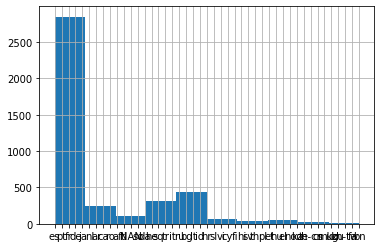

In [12]:
#df['Lang'].hist()
df[df['Lang']!='en']['Lang'].hist()
df[df['Lang']!='en']['Lang'].describe()

In [13]:
### Length of tweets

In [14]:
def df_len(text):
    try:
        return len(text)
    except:
        return -1

In [15]:
df['Len']=df['text'].apply(df_len)

In [16]:
# 3 tweets have no text. Weird.
df[df['Len']==-1]

,date,username,to,replies,retweets,favorites,text,geo,mentions,hashtags,id,permalink,Lang,Len
2472,2017-06-01 20:18:29,NickyB4Prez,luckytoo3,0,1,1,NaN,NaN,NaN,NaN,870374011917807616,https://twitter.com/NickyB4Prez/status/8703740...,NAN,-1
4011,2017-06-01 18:25:08,ifal78,mario_campa,1,0,1,NaN,NaN,NaN,NaN,870345484551864320,https://twitter.com/ifal78/status/870345484551...,NAN,-1
11657,2017-06-01 11:30:21,GA_TeaParty,GA_TeaParty,0,0,0,NaN,NaN,NaN,NaN,870241101843705860,https://twitter.com/GA_TeaParty/status/8702411...,NAN,-1


In [17]:
# Looks like it
df[df['id']==870374011917807616]

,date,username,to,replies,retweets,favorites,text,geo,mentions,hashtags,id,permalink,Lang,Len
2472,2017-06-01 20:18:29,NickyB4Prez,luckytoo3,0,1,1,NaN,NaN,NaN,NaN,870374011917807616,https://twitter.com/NickyB4Prez/status/8703740...,NAN,-1


In [18]:
# Remove these from the data frame 
df=df.drop(df[df['Len']==-1].index.to_numpy())

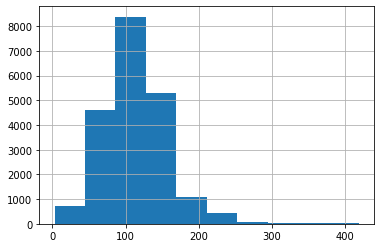

In [19]:
# Anyway, the tasty histogram shows a peak around 140 (makes sense. Only non-Asian langs can post upto 280 chars, after Nov 2017)
df['Len'].hist()

'Bitcoin: more than what the article suggested. Virtual vertigo: What if the bitcoin bubble bursts? http://www.economist.com/news/leaders/21722841-latest-frenzy-tulip-mania-gold-rush-or-dotcom-boom-what-if-bitcoin-bubble?cid1=cust/ednew/n/bl/n/2017061n/owned/n/n/nwl/n/n/ap/35302/n via @TheEconomist'

In [36]:
# Weird
{df[df['Len']>280]['text'][292], str(len(df[df['Len']>280]['text'][292])) + " Characters"}
# All URLS count as 23 characters. 
# This length of tweet is NOT the same as the Twitter 'character length' for this (and similar) reason

{'298 Characters',
 'Bitcoin: more than what the article suggested. Virtual vertigo: What if the bitcoin bubble bursts? http://www.economist.com/news/leaders/21722841-latest-frenzy-tulip-mania-gold-rush-or-dotcom-boom-what-if-bitcoin-bubble?cid1=cust/ednew/n/bl/n/2017061n/owned/n/n/nwl/n/n/ap/35302/n via @TheEconomist'}

In [21]:
### Time to clean up the text
# Note that ntlk has difficulty with common abbreviations used in everyday English (idk, wht, u, etc.)

In [22]:
import string
from nltk.corpus import stopwords

In [23]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [24]:
text_process("I ah, he. aaa")

['ah', 'aaa']

In [25]:
df['text'].head(5).apply(text_process)

0    [dont, entirely, trust, bitcoin, another, manm...
1    [Bitcoin, Mining, httpswwwyoutubecomwatchvGmOz...
2    [Trump, really, signalling, COVFEFE, Code, BUY...
3         [Bitcoin, Needs, Washington, Go, Mainstream]
4    [Australia, seguir, mientras, que, Rusia, la, ...
Name: text, dtype: object

### Bag-of-words model
####    Count how many times does a word occur in each message (Known as term frequency)
####    Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)
####    Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

#### 1. Each word can have positive, negative or neutral sentiments.
#### 2. These words, when combined in different way would change the semantics of it - we call this compositionality.
#### Eg 'awesome' is postive, but placing 'not' in front of it makes it negative. Need to make sure B-o-W accounts for this...

In [91]:
from sklearn.feature_extraction.text import CountVectorizer

In [170]:
# Create a word-count space from all the text, where each dimension is a unique word
bow_transformer = CountVectorizer(analyzer=text_process).fit(df['text'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

39174


In [171]:
# Get the coordinates of a sentence / tweet in this space (note it requires proper english)
bow4 = bow_transformer.transform(["BTC 2 da moon!!!"])
bow4A = bow_transformer.transform(["BTC to the moon!!!"])
print(bow4)
print(bow4A)

  (0, 998)	1
  (0, 4197)	1
  (0, 16366)	1
  (0, 31663)	1
  (0, 4197)	1
  (0, 31663)	1


In [193]:
# You can find a word from a dimension-id, and vice-versa
# This is also good to check if words appear at all. Eg increase appears but decrease doesn't
print(bow_transformer.get_feature_names()[4509]) # This appears twice
print(bow_transformer.vocabulary_['increase'])

Bitcoin
30050


In [173]:
# Now transform the entire dataframe of tweets into this 'word count'space
messages_bow = bow_transformer.transform(df['text'])

In [178]:
# the dimension of our matrix which represents the tweets in 'word count' space is 
# "The number of tweets"x"Number of unique words"
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (20709, 39174)
Amount of Non-Zero occurences:  203877


In [179]:
# ?
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 0


In [116]:
#The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. 
# Now, assume we have 10 million documents and the word cat appears in one thousand of these. 
# Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4. 
# Thus, the Tf-idf weight is the product of these quantities: 0.03 * 4 = 0.12.

#### calculate the tf-idf weights for our tweet-word-count data

In [185]:
from sklearn.feature_extraction.text import TfidfTransformer
# The tfidf transformer takes in the word-count matrix representation of a sentence, and computes it's weighting
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 31663)	0.6556010003454573
  (0, 16366)	0.5124495492953985
  (0, 4197)	0.30548173214884244
  (0, 998)	0.4628862701531786


In [194]:
# How balanced are these text messages. Eg how many more times does 'boom'appear than ';bust', etc
#print(tfidf_transformer.idf_[bow_transformer.vocabulary_['decrease']]) # 'decrease' doesn't show up!!
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['increase']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['bitcoin']])

8.373422596928094
1.901433041832843


In [195]:
# Now convert the entire tweet word count data set
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(20709, 39174)


#### By now the text has been Vectorized, and we can feed it into a model

##### This example trains a model to detect the language of the tweet. Just for fun

In [ ]:

from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(messages_tfidf, df['Lang'])

In [137]:
print('predicted:', spam_detect_model.predict(tfidf4)[0])
print('expected:', df.Lang[3])

predicted: en
expected: en


In [138]:
all_predictions = spam_detect_model.predict(messages_tfidf)
print(all_predictions)

['en' 'en' 'en' ... 'en' 'en' 'en']


#### Time to run a trained spam classifyer on it

## TEXTBLOB Approach

In [38]:
#https://medium.com/better-programming/twitter-sentiment-analysis-15d8892c0082

#### 1. Want a collection of tweet texts (cleaned - w/o '#','@', etc)

In [156]:
from textblob import TextBlob
from wordcloud import WordCloud
import re
import matplotlib.pyplot as plt
import numpy


In [157]:
# Create a dataframe with a column called Tweets
df_tb = pd.DataFrame({'Tweets' : df['text']})
# Show the first 5 rows of data
{type(df_tb['Tweets'][1]),df_tb['Tweets'][1]}

{str,
 'What is #Bitcoin Mining? https://www.youtube.com/watch?v=GmOzih6I1zs To get started mining - go to https://www.genesis-mining.com/a/694870 #Bitcoin '}

In [158]:
# Making sure those 'Nans' don't show up.. They aren't strings!
a=[isinstance(i, str) for i in df_tb['Tweets']]
df_tb=df_tb[a]

In [159]:
# Create a function to clean the tweets
def cleanTxt(text):
 if type(text)!=str:
    print(type(text))
 text = re.sub('@[A-Za-z0–9]+', '', text) #Removing @mentions
 text = re.sub('#', '', text) # Removing '#' hash tag
 text = re.sub('RT[\s]+', '', text) # Removing RT
 text = re.sub('https?:\/\/\S+', '', text) # Removing hyperlink
 text = re.sub('Bitcoin', '', text) # Removing hyperlink    
 text = re.sub('bitcoin', '', text) # Removing hyperlink    
 text = re.sub('BTC', '', text) # Removing hyperlink    
 text = re.sub('blockchain', '', text) # Removing hyperlink    
 return text

# Clean the tweets
df_tb['Tweets']=df_tb['Tweets'].apply(cleanTxt)

# Show the cleaned tweets
df_tb

,Tweets
0,I don't entirely trust . It's another man-made...
1,What is Mining? To get started mining - go t...
2,What was Trump really signalling with COVFEFE?...
3,Why Needs Washington to Go Mainstream
4,"Australia a seguir, mientras que Rusia y la In..."
...,...
20707,- Price: $2286.41 Change in 1h: -0.21% Marke...
20708,"Average market price is: USD 2,298.01, EUR 2,..."
20709,"Best faucet of the day, voted 19 times is Moo..."
20710,Monacoin 31.2円↑[Zaif] -円→[もなとれ] NEM XEM 23.24円...


In [160]:
# Create a function to get the subjectivity (fact=0, opinion=1)
def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity (neg = -1, pos = +1)
def getPolarity(text):
   return  TextBlob(text).sentiment.polarity


# Create two new columns 'Subjectivity' & 'Polarity'
df_tb['Subjectivity'] = df_tb['Tweets'].apply(getSubjectivity)
df_tb['Polarity'] = df_tb['Tweets'].apply(getPolarity)

# Show the new dataframe with columns 'Subjectivity' & 'Polarity'
df_tb

,Tweets,Subjectivity,Polarity
0,I don't entirely trust . It's another man-made...,0.625000,0.000000
1,What is Mining? To get started mining - go t...,0.000000,0.000000
2,What was Trump really signalling with COVFEFE?...,0.200000,0.312500
3,Why Needs Washington to Go Mainstream,0.000000,0.000000
4,"Australia a seguir, mientras que Rusia y la In...",0.000000,0.000000
...,...,...,...
20707,- Price: $2286.41 Change in 1h: -0.21% Marke...,0.000000,0.000000
20708,"Average market price is: USD 2,298.01, EUR 2,...",0.400000,-0.150000
20709,"Best faucet of the day, voted 19 times is Moo...",0.525000,0.500000
20710,Monacoin 31.2円↑[Zaif] -円→[もなとれ] NEM XEM 23.24円...,0.000000,0.000000


{<matplotlib.axes._subplots.AxesSubplot at 0x7f162bcda320>}

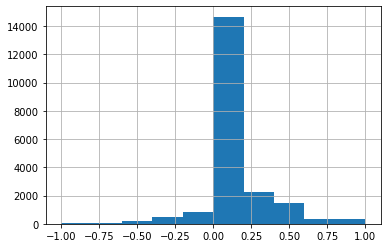

In [161]:
# Skew towards positive sentiments, although largely neutral (according to the algo.)
{df_tb['Polarity'].hist()}

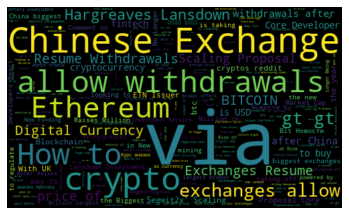

In [162]:
# word cloud visualization
allWords = ' '.join([twts for twts in df_tb['Tweets']])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [163]:
# Create a function to compute negative (-1), neutral (0) and positive (+1) analysis
def getAnalysis(score):
    if score < 0:
      return 'Negative'
    elif score == 0:
      return 'Neutral'
    else:
      return 'Positive'

df_tb['Analysis'] = df_tb['Polarity'].apply(getAnalysis)# Show the dataframe

df_tb

,Tweets,Subjectivity,Polarity,Analysis
0,I don't entirely trust . It's another man-made...,0.625000,0.000000,Neutral
1,What is Mining? To get started mining - go t...,0.000000,0.000000,Neutral
2,What was Trump really signalling with COVFEFE?...,0.200000,0.312500,Positive
3,Why Needs Washington to Go Mainstream,0.000000,0.000000,Neutral
4,"Australia a seguir, mientras que Rusia y la In...",0.000000,0.000000,Neutral
...,...,...,...,...
20707,- Price: $2286.41 Change in 1h: -0.21% Marke...,0.000000,0.000000,Neutral
20708,"Average market price is: USD 2,298.01, EUR 2,...",0.400000,-0.150000,Negative
20709,"Best faucet of the day, voted 19 times is Moo...",0.525000,0.500000,Positive
20710,Monacoin 31.2円↑[Zaif] -円→[もなとれ] NEM XEM 23.24円...,0.000000,0.000000,Neutral


{'Error : ', 2472}
{'Error : ', 4011}
{'Error : ', 11657}


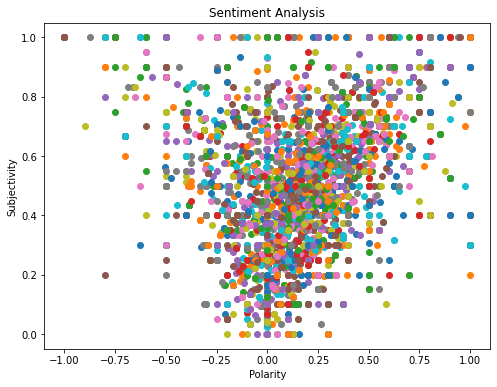

20709

In [177]:
# Plotting (Takes a few minutes)
# 2472, 4011, 11657, are bad data points..
plt.figure(figsize=(8,6))

for i in range(0, df_tb.shape[0]):
    try:
        plt.scatter(df_tb["Polarity"][i], df_tb["Subjectivity"][i])
    except:
        print({"Error : ",i})
    
#plt.scatter(x,y,color)   
plt.title('Sentiment Analysis') 
plt.xlabel('Polarity') 
plt.ylabel('Subjectivity') 
plt.show()
df_tb.shape[0]

In [187]:
df_tb.iloc[2472]

Tweets          Intend to agree, away from  onto second layers...
Subjectivity                                                    0
Polarity                                                        0
Analysis                                                  Neutral
Name: 2473, dtype: object

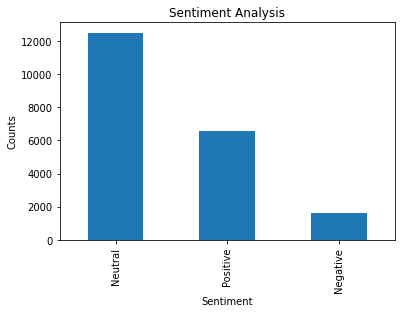

In [181]:
# Plotting and visualizing the counts
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df_tb['Analysis'].value_counts().plot(kind = 'bar')
plt.show()